In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
import pulse_compiler_helper_fns

In [4]:
q.IBMQ.load_account() # Load account from disk

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [5]:
provider = q.IBMQ.get_provider(group='qiskit-terra', project='pulse-testing')
backend = provider.get_backend('alt_almaden')
#from qiskit.test.mock import FakeAlmaden
#backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


In [6]:
theta = np.pi / 2
phi = theta * 1.1849141858184884 / 8.649346371694238
num_trotter_steps = 6

In [7]:
schedules = []

In [8]:
HH = cmd_def.get('u2', qubits=[0], P0=0, P1=np.pi) | cmd_def.get('u2', qubits=[1], P0=0, P1=np.pi)

RZRZ = cmd_def.get('u1', qubits=[0], P0=theta) | cmd_def.get('u1', qubits=[1], P0=phi)

CNOT_RZ_CNOT = cmd_def.get('cx', qubits=[0, 1])
CNOT_RZ_CNOT |= cmd_def.get('u1', qubits=[1], P0=theta) << CNOT_RZ_CNOT.duration
CNOT_RZ_CNOT |= cmd_def.get('cx', qubits=[0, 1]) << CNOT_RZ_CNOT.duration

schedule = HH
for _ in range(num_trotter_steps):
    schedule |= RZRZ << schedule.duration
    schedule |= CNOT_RZ_CNOT << schedule.duration
schedule |= HH << schedule.duration
schedule |= measure << schedule.duration

schedules.append(schedule)

In [9]:
## Optimized Way:
circuit = q.QuantumCircuit(2)
circuit.h(0); circuit.h(1);
for _ in range(num_trotter_steps):
    circuit.rz(theta, 0); circuit.rz(phi, 1);
    circuit.zz_interaction(theta, 0, 1)
circuit.h(0); circuit.h(1);

decomposed_circuit = circuit.decompose()

pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(decomposed_circuit, backend, optimization_level=1)

schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
schedule |= measure << schedule.duration
schedules.append(schedule)

/Users/alijavadi/Desktop/ajavadia-terra/qiskit/providers/models/backendconfiguration.py:399: UserWarning: The control channel appropriate for an interaction should be determined from the hamiltonian. This will be determined for you in the future.
  warnings.warn("The control channel appropriate for an interaction should be determined "


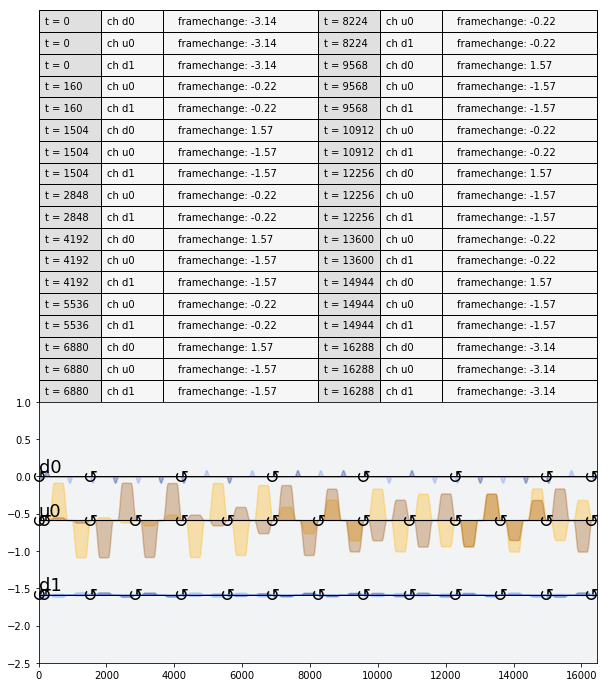

In [10]:
schedules[0].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

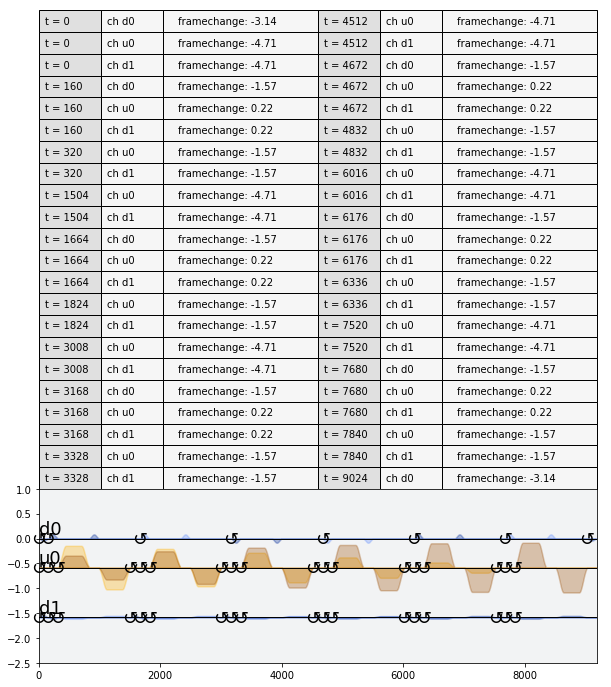

In [11]:
schedules[1].draw(channels=[config.drive(0), config.drive(1), config.control(0)])

In [12]:
shots = 8000
job = q.execute(schedules, backend=backend, shots=shots)
print('job is %s' % job.job_id())

job is 5ddc5e286b72bd00113d271a


/anaconda3/lib/python3.6/site-packages/ipywidgets/widgets/widget_layout.py:84: DeprecationWarning: Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead
  warnings.warn("Layout properties overflow_x and overflow_y have been deprecated and will be dropped in a future release. Please use the overflow shorthand property instead", DeprecationWarning)


In [13]:
job.status()

<JobStatus.VALIDATING: 'job is being validated'>

# Run a mitigation cal job

In [14]:
import qiskit.ignis.mitigation.measurement as mit
meas_qcs, meas_labels = mit.complete_meas_cal(qubit_list=[0,1])
meas_qcs_transpiled = q.transpile(meas_qcs, backend, basis_gates=['x'])
meas_schedules = q.schedule(meas_qcs_transpiled, backend=backend, cmd_def=cmd_def)

In [15]:
job_mit = q.execute(meas_schedules, backend, shots=shots)
print('job_mit is %s' % job_mit.job_id())

job_mit is 5ddc5e3f2865b20011f57528


In [30]:
job_mit.status()

<JobStatus.DONE: 'job has successfully run'>

-----
## Analysis

In [17]:
from qiskit.result import marginal_counts

In [18]:
result = job.result()

'Connection with websocket closed unexpectedly: Unexpected error(status_code=1006)'
Retrying get_job_status after 0.5 seconds: Attempt #1.
'Connection with websocket closed unexpectedly: Unexpected error(status_code=1006)'
Retrying get_job_status after 0.5 seconds: Attempt #1.


In [19]:
# mitigate results
result_mit = marginal_counts(job_mit.result(), [0,1])
readout_fitter = mit.CompleteMeasFitter(result_mit, meas_labels)
readout_fitter.cal_matrix

array([[9.5425e-01, 7.4250e-02, 7.5125e-02, 7.0000e-03],
       [3.1250e-02, 9.0825e-01, 3.7500e-03, 6.4000e-02],
       [1.3750e-02, 2.1250e-03, 8.9600e-01, 9.3250e-02],
       [7.5000e-04, 1.5375e-02, 2.5125e-02, 8.3575e-01]])

In [20]:
standard_counts = marginal_counts(result.get_counts(0), [0,1])
print('before mitigation:')
print(standard_counts)

standard_counts = readout_fitter.filter.apply(standard_counts)
print('\n\n\n after mitigation:')
print(standard_counts)

before mitigation:
{'00': 3318, '01': 564, '10': 3667, '11': 451}



 after mitigation:
{'00': 3122.6505200340957, '01': 468.268871427001, '10': 4001.1481789838217, '11': 407.9324295550808}


In [21]:
optimized_counts = marginal_counts(result.get_counts(1), [0,1])
print('before mitigation:')
print(optimized_counts)

optimized_counts = readout_fitter.filter.apply(optimized_counts)
print('\n\n\n after mitigation:')
print(optimized_counts)

before mitigation:
{'00': 3346, '01': 189, '10': 4188, '11': 277}



 after mitigation:
{'00': 3137.128802495741, '01': 67.82471420098143, '10': 4606.144654959527, '11': 188.90182834375085}


In [22]:
# sanitize data and plot
for key in standard_counts:
    standard_counts[key] = int(standard_counts[key])
for key in optimized_counts:
    optimized_counts[key] = int(optimized_counts[key])

In [23]:
standard_counts

{'00': 3122, '01': 468, '10': 4001, '11': 407}

In [24]:
optimized_counts

{'00': 3137, '01': 67, '10': 4606, '11': 188}

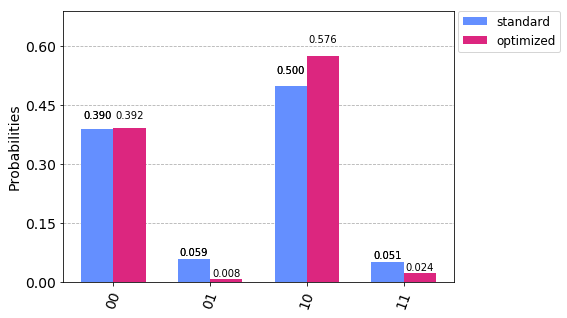

In [25]:
from qiskit.visualization import plot_histogram
plot_histogram([standard_counts, optimized_counts], legend=['standard', 'optimized'])

In [26]:
ideal_counts = {'00': .82593*4000, '10': .17407*4000}  # https://algassert.com/quirk#circuit=%7B%22cols%22%3A%5B%5B%22H%22%2C%22H%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.21519069426%22%7D%5D%2C%5B%22Z%5E%C2%BD%22%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.21519069426%22%7D%5D%2C%5B%5D%2C%5B%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22Z%5E%C2%BD%22%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.21519069426%22%7D%5D%2C%5B%5D%2C%5B%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%7B%22id%22%3A%22Rzft%22%2C%22arg%22%3A%220.21519069426%22%7D%5D%2C%5B%5D%2C%5B%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B1%2C%22Z%5E%C2%BD%22%5D%2C%5B%22%E2%80%A2%22%2C%22X%22%5D%2C%5B%22H%22%2C%22H%22%5D%5D%7D
# standard_counts =
# optimized_counts = {'00': 3.2117147307346117e-09, '01': 4201.575210406215, '10': 3798.4247895903336, '11': 2.401224165590816e-10}

In [27]:
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.kl_divergence(ideal_counts, optimized_counts))

0.43525467033287335
0.40678415024505554


In [28]:
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, standard_counts))
print(pulse_compiler_helper_fns.cross_entropy(ideal_counts, optimized_counts))

0.8975360550417985
0.8690655349539805


In [29]:
from qiskit.quantum_info import hellinger_fidelity
print(hellinger_fidelity(ideal_counts, standard_counts))
print(hellinger_fidelity(ideal_counts, optimized_counts))

0.6297207853684704
0.6620373759074387
